# Visualize entity statistics for annotated molecular dynamics texts 📊

### 🎯 Objectives
- Retrieve a dataframe summarizing, for each annotated text, the number of entities per class: MOLECULE (`MOL`), FORCEFIELD (`FFM`), SIMULATION_TIME (`STIME`), TEMPERATURE (`TEMP`), SOFTWARE NAME (`SOFTNAME`) and SOFTWARE VERSION (`SOFTVERS`).
- Get an overview of the entities present across all annotations.

## Load libraries

In [15]:
import math
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
%load_ext watermark
%watermark
%watermark --packages numpy,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-12-03T12:13:23.665315+01:00

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 8.13.2

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 6.14.0-35-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

numpy     : 2.3.4
pandas    : 2.2.3
matplotlib: 3.10.7



In [17]:
# Directories and files.
RESULTS_FILE = Path("../results/all_annotations_entities_count.tsv")
ANNOTATION_DIR = Path("../annotations/v2")

## Load results

In [18]:
def load_tsv(path: Path) -> pd.DataFrame:
    """Load a TSV file into a pandas DataFrame.

    Parameters
    ----------
    path : Path
        The filesystem path to the TSV file.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the contents of the TSV file.
    """
    df = pd.read_csv(path, sep="\t")
    return df


df = load_tsv(RESULTS_FILE)
df

,filename,text_length,TEMP_nb,SOFTNAME_nb,SOFTVERS_nb,STIME_nb,MOL_nb,FFM_nb
0,figshare_14511885.json,2075,0,3,0,1,17,0
1,figshare_5642866.json,1280,0,0,0,2,10,0
2,figshare_8292209.json,1114,0,0,0,0,7,0
3,zenodo_3248612.json,576,3,1,1,1,14,2
4,zenodo_6980700.json,639,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...
375,figshare_1586671.json,2267,0,0,0,0,3,0
376,figshare_12661589.json,2139,2,0,0,0,17,0
377,figshare_21285264.json,749,0,0,0,0,8,0
378,figshare_7924394.json,1174,0,0,0,1,8,0


## Global distribution of classes

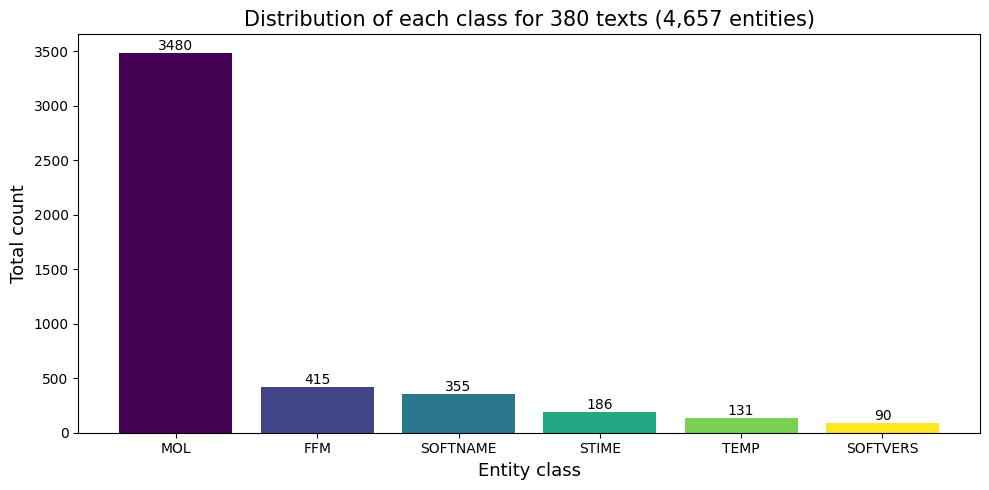

In [19]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    """Plot a bar chart showing the total number of entities per class across all files.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing columns ending with ``_nb`` representing
        the counts of each entity class.
    """
    total_entities = len(df)
    cols = [col for col in df.columns if col.endswith("_nb")]
    summary = df[cols].sum().sort_values(ascending=False)

    classes = [col.replace("_nb", "") for col in summary.index]
    counts = summary.to_numpy()

    cmap = mpl.colormaps.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(10, 5))
    x = np.arange(len(classes))
    bars = plt.bar(x, counts, color=colors)
    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.0f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.title(
        f"Distribution of each class for {total_entities} texts"
        f" ({np.sum(counts):,} entities)",
        fontsize=15,
    )
    plt.xlabel("Entity class", fontsize=13)
    plt.ylabel("Total count", fontsize=13)
    plt.xticks(x, classes)
    plt.tight_layout()
    plt.show()


plot_class_distribution(df)

## Distribution per class

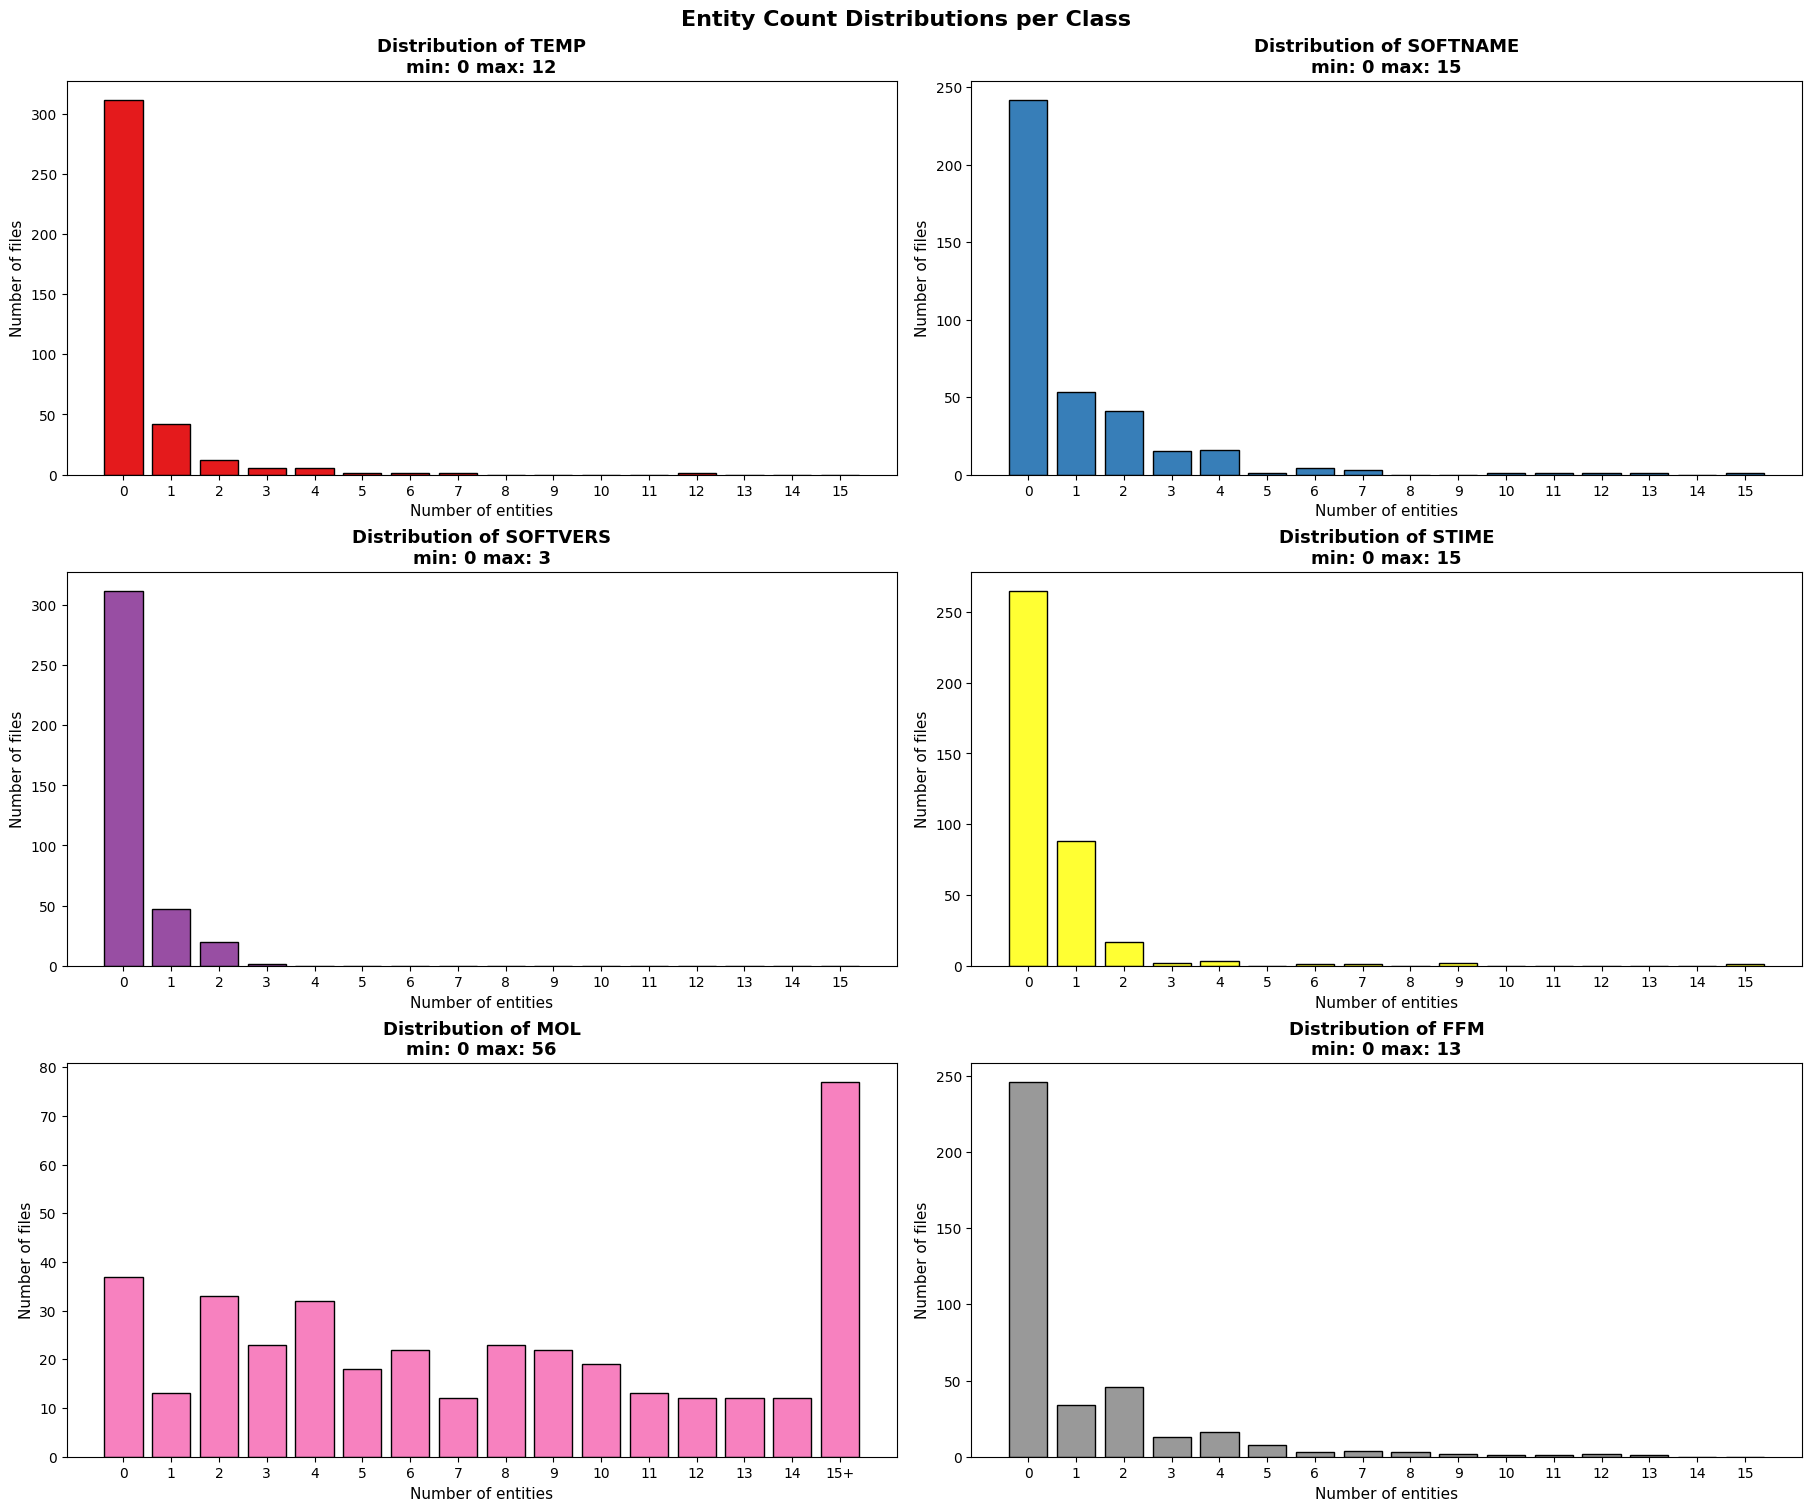

In [ ]:
def plot_histograms(df: pd.DataFrame) -> None:
    """Plot histograms of entity counts per class.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns ending with '_nb' = counts of each entity class.
    """
    cols = [col for col in df.columns if col.endswith("_nb")]
    n_classes = len(cols)

    cmap = mpl.colormaps.get_cmap("Set1")
    colors = cmap(np.linspace(0, 1, n_classes))

    n_cols = 2
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(18, 5 * n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[col]
        max_val = int(data.max())
        # Define bins, tics and labels.
        max_bins = 15
        bins = np.arange(0, max_bins + 1)
        labels = [str(label) for label in np.arange(0, max_bins)]
        # Add last boundary depending on data beyond the fixed boundary.
        if max_val <= max_bins:
            bins = np.append(bins, max_bins + 1)
            labels = [*labels, f"{max_bins}"]
        else:
            bins = np.append(bins, max_val)
            labels = [*labels, f"{max_bins}+"]
        ticks = np.arange(0, len(bins) - 1) + 0.5
        # Compute histogram values first.
        heights, _ = np.histogram(data, bins=bins)
        # Plot historam.
        ax.bar(
            x=ticks,
            height=heights,
            color=colors[i],
            edgecolor="black",
        )
        # Add appropriate ticks.
        ax.set_xticks(ticks=ticks, labels=labels)
        title = f"Distribution of {col.replace('_nb', '')}"
        title += f"\nmin: {int(data.min())} max: {int(data.max())}"
        ax.set_title(
            title,
            fontsize=13,
            fontweight="bold",
        )
        ax.set_xlabel("Number of entities", fontsize=11)
        ax.set_ylabel("Number of files", fontsize=11)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Entity Count Distributions per Class", fontsize=16, fontweight="bold")
    plt.show()


plot_histograms(df)